In [155]:
import nibabel as nib
import pandas as pd
a = nib.load('data/Train/001/001_ES.nii').get_fdata()
meta = pd.read_csv('data/metaDataTrain.csv')
h = meta['Height'][0]
w = meta['Weight'][0]


In [186]:
a = np.random.randn(10)
b = np.random.randn(10)
c = np.random.randn(10)

In [184]:
buf = np.concatenate((a,b))

In [187]:
buf = np.concatenate((buf,c))

In [195]:
import os
c = 1
for dirname, _, filenames in os.walk('data/Train/'):
    for filename in filenames:
        if filename.endswith("ED.nii") and not filename.endswith("_seg.nii"):
            #if (c != 1):
                #buf = np.concatenate((buf,nib.load(os.path.join(dirname, filename)).get_fdata()))
            a = nib.load(os.path.join(dirname, filename)).get_fdata()
            print (a.shape)
            c += 1
            #print(os.path.join(dirname, filename))

(192, 256, 10)
(256, 256, 8)
(216, 256, 9)
(216, 256, 10)
(240, 256, 10)
(256, 256, 10)
(256, 216, 10)
(216, 256, 7)
(222, 224, 10)
(216, 256, 9)
(216, 256, 10)
(208, 256, 8)
(200, 256, 7)
(240, 256, 9)
(216, 256, 6)
(208, 256, 8)
(256, 256, 8)
(256, 216, 10)
(224, 154, 16)
(216, 256, 11)
(184, 256, 10)
(208, 256, 10)
(174, 208, 15)
(180, 224, 14)
(256, 256, 9)
(208, 256, 6)
(216, 256, 7)
(216, 256, 10)
(216, 256, 8)
(216, 256, 9)
(216, 256, 7)
(174, 224, 12)
(232, 256, 10)
(208, 256, 12)
(256, 216, 9)
(208, 256, 13)
(216, 256, 9)
(224, 256, 10)
(216, 256, 8)
(200, 256, 10)
(216, 256, 9)
(256, 216, 10)
(210, 224, 8)
(216, 256, 10)
(256, 216, 9)
(168, 224, 14)
(256, 216, 9)
(256, 216, 9)
(180, 224, 10)
(154, 224, 17)
(192, 256, 10)
(256, 216, 7)
(154, 224, 16)
(224, 256, 10)
(216, 256, 9)
(216, 256, 7)
(216, 256, 8)
(208, 256, 9)
(208, 256, 8)
(256, 208, 9)
(216, 256, 8)
(154, 224, 7)
(224, 154, 16)
(180, 224, 8)
(192, 256, 7)
(216, 256, 8)
(256, 176, 8)
(216, 304, 8)
(184, 288, 15)
(20

In [156]:
import torch
a = torch.tensor(a, dtype=torch.float32)
a = a/a.max()

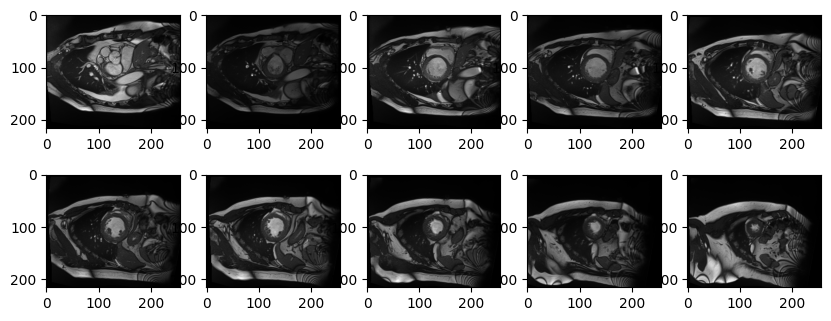

In [157]:
import matplotlib.pyplot as plt 
for i in range(a.shape[2]):
    plt.subplot(5, 5,i + 1)
    plt.imshow(a[:,:,0 + i], cmap='gray')
    plt.gcf().set_size_inches(10, 10)
plt.show()

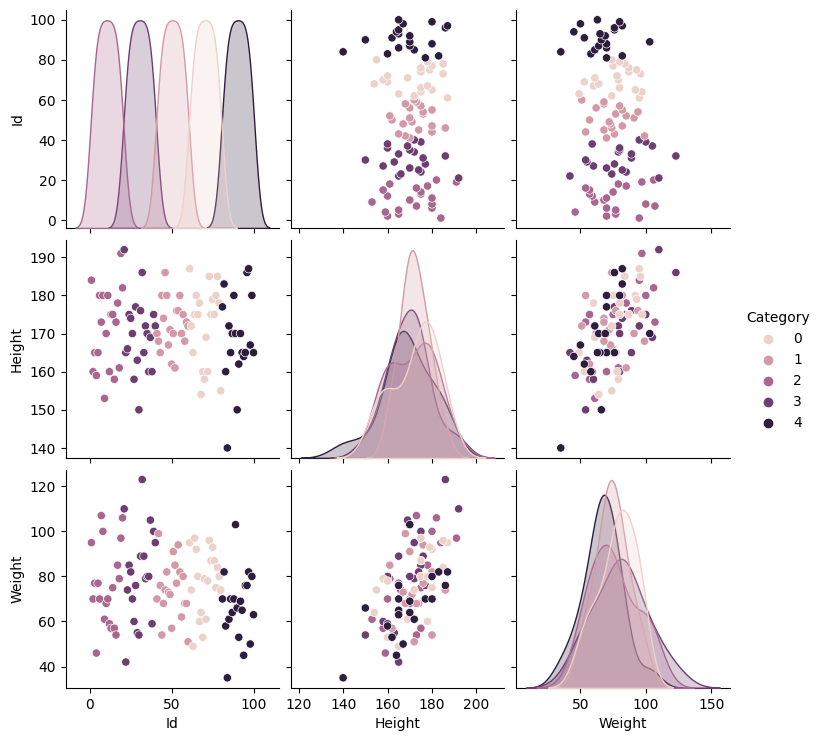

In [158]:
#plot correlation of height, weight and category
import seaborn as sns  
#sns.set(style='darkgrid', palette='colorblind')
sns.pairplot(meta, hue='Category')


<AxesSubplot: >

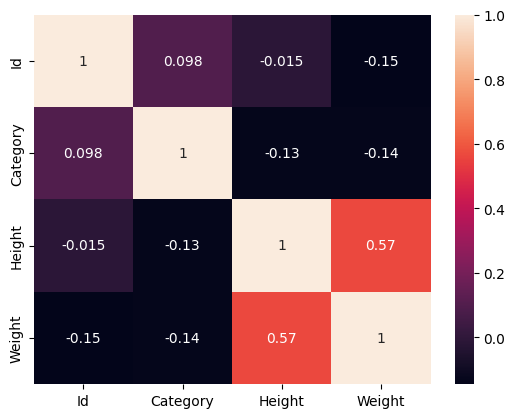

In [159]:
corr = meta.corr()
sns.heatmap(corr, annot=True)

In [160]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class MRI_Classifier(nn.Module):
    def __init__(self):
        super(MRI_Classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64*27*32+2 ,128)
        self.fc2 = nn.Linear(128, 5)
        
    def forward(self, x, weight, height):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.tensor(np.append(x.detach().numpy(), [w,h]), dtype=torch.float32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [161]:
#reshape a into (batch, channel, height, waidth) in function of its shape
a = a.reshape(1, a.shape[-1], a.shape[0], a.shape[1])

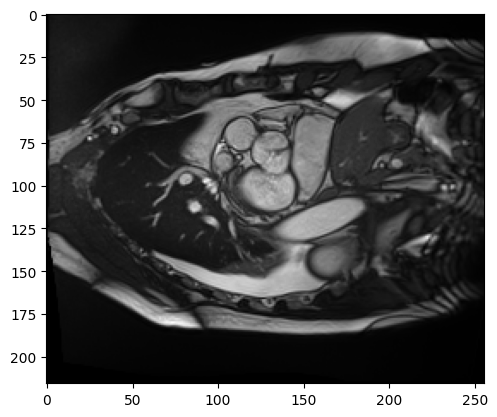

In [162]:
plt.imshow(a.reshape(216, 256,10)[: ,:,0], cmap='gray')

In [165]:
#training loop
epochs = 10
lr = 0.001
batch_size = 1

model = MRI_Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    for i in range(0, len(meta), batch_size):
        x = torch.tensor(a, dtype=torch.float32)
        y = torch.tensor(meta['Category'][i], dtype=torch.long)
        w = torch.tensor(meta['Weight'][i], dtype=torch.float32)
        h = torch.tensor(meta['Height'][i], dtype=torch.float32)
        pred = model(x, w, h)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

/tmp/ipykernel_38432/1879152815.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(a, dtype=torch.float32)


Epoch 1/10, Loss: 1.5880
Epoch 2/10, Loss: 1.5903
Epoch 3/10, Loss: 1.5916
Epoch 4/10, Loss: 1.5926
Epoch 5/10, Loss: 1.5934
Epoch 6/10, Loss: 1.5941
Epoch 7/10, Loss: 1.5948
Epoch 8/10, Loss: 1.5954
Epoch 9/10, Loss: 1.5960
Epoch 10/10, Loss: 1.5965


In [164]:
import torch
model = MRI_Classifier()
model(a, w, h)

tensor([-0.0054, -0.1505, -0.1603,  0.0563, -0.3511], grad_fn=<AddBackward0>)

In [75]:
np.append(b.numpy(), [w,h])

array([  0.,  30.,   0., ...,   0.,  95., 184.])

In [73]:
b

tensor([ 0., 30.,  0.,  ...,  0.,  0.,  0.])

In [38]:
a[0][0][0][0] + h

tensor(184., dtype=torch.float64)

In [70]:
import torch
model = MRI_Classifier()
model(a)

tensor([[-0.0631, -0.0209,  0.0152, -0.0315, -0.0381]],
       grad_fn=<AddmmBackward0>)

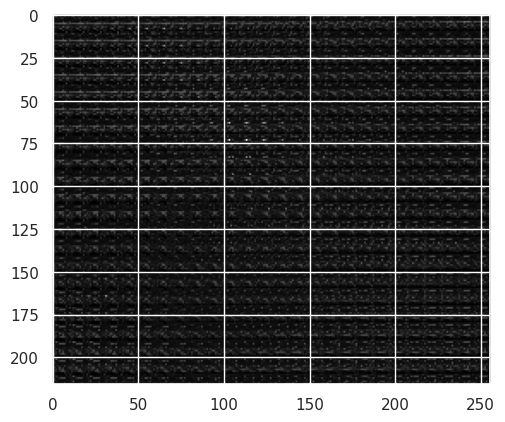

In [85]:

plt.imshow(a[0,5,:,:], cmap='gray')

In [87]:
a.shape

torch.Size([1, 10, 216, 256])

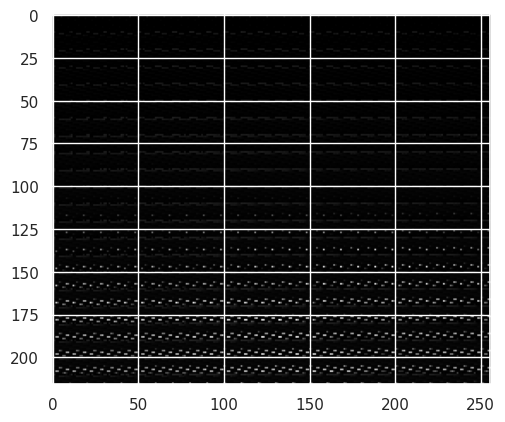

In [91]:
plt.imshow(a[:,0,:,:].reshape(216, 256), cmap='gray')

In [20]:
torch.randn(10, 28, 28).shape

torch.Size([10, 28, 28])